<p style="font-size:25px;">Geospatial Data Analysis</p>
<p style="font-size:22px;">Excercise 5.2</p>
<p style="font-size:18px;">Sotiris Pelekis - Dsml - 03400069</p>

# Data loading and preprocessing

## Input features import and reshaping

In [1]:
import os 
import numpy as np

X = np.load(os.path.join("data", "partB", "indianpinearray.npy"))
print("Initial shape: ", X.shape)
X = X.reshape(-1,200)
print("Final shape: ", X.shape)

Initial shape:  (145, 145, 200)
Final shape:  (21025, 200)


## Ground truth import and reshaping

In [2]:
y = np.load(os.path.join("data", "partB", "IPgt.npy"))
print("Initial shape: ", y.shape)
y = y.reshape(-1)
print("Final shape: ", y.shape)
print("Classes: ", np.unique(y))

Initial shape:  (145, 145)
Final shape:  (21025,)
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


## Data cleaning 

There is also class 0 in the dataset. I remove class 0 which corresponds to unlabeled data.

In [3]:
X = X[y!=0]
y = y[y!=0]
y=y-1
print("Final shapes: ", X.shape, y.shape)
print("Classes: ", np.unique(y))

Final shapes:  (10249, 200) (10249,)
Classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


## Train/Test split

In this section I perform the splitting to training and test set. As this test set was used for hyperparameter tuning that is: early stopping and checkpoints, the definition of the architecture of the MLPs, as well as the regularization factors and the learning rates I will refer to it as "validation set" from now on.

In [4]:
from sklearn.model_selection import train_test_split
# Split to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69, stratify=y)

## Standardization

I standardize the data to have mean=0 and std=1. I need to apply separate normalisation to the training and test sets in order for the training process to be fair.

In [5]:
# Standardization
from sklearn import preprocessing
sc = preprocessing.StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

## Class statistics 

Training set shape      :  (7174, 200)
Training labels shape   :  (7174,)
Test set shape    :  (3075, 200)
Test labels shape :  (3075,)
Training set frequencies [32, 1000, 581, 166, 338, 511, 20, 335, 14, 680, 1718, 415, 144, 885, 270, 65]


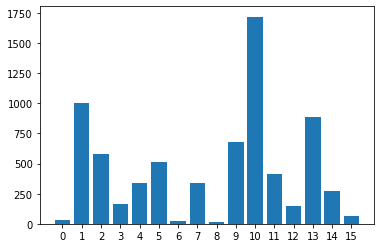

Test set frequencies [14, 428, 249, 71, 145, 219, 8, 143, 6, 292, 737, 178, 61, 380, 116, 28]


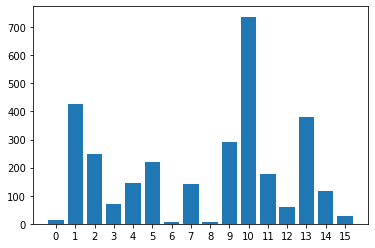

In [6]:
# Split training set to training and validation set
print('Training set shape      : ', X_train.shape)
print('Training labels shape   : ', y_train.shape)
print('Test set shape    : ', X_test.shape)
print('Test labels shape : ', y_test.shape)

import matplotlib.pyplot as plt
def hist(y, title):
    freq = [list(y).count(i) for i in np.unique(y)]
    print(title, freq)
    plt.bar(np.unique(y), height=freq)
    plt.xticks(np.unique(y))
    return plt
hist(y_train, "Training set frequencies").show()
hist(y_test, "Test set frequencies").show()

Indeed, classes are totally imbalanced, however I retained equal proportions between training and test set which will help the training process.

# Classic ML approach (SVM, Random Forest) - Training & Validation stage
## Hyperparameter tuning and validation of the models

At first I train the classifiers using the GridSearch algorithm so as to decide the best hyperparameter values based on accuracy. I try many different hyperparameter values for both kernel SVM and RandomForest algorithms. I also split in training/ test set, equally balancing all classes and I use less samples for tuning given that especially the RF algorithm is really resource consuming. We also use stratified K-Fold in GridSearch so as to be sure that cross validation is performed with balanced splits using StratifiedKFold CV.

In [7]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

In [8]:
#Set the parameters of each model by cross-validation gridsearch
models = {'SVM': SVC(),
          'Random Forest': RandomForestClassifier(n_jobs=-1)}

param_grid = [{'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'C': [10, 100, 1000]},
                    {'n_estimators': [200, 600], 'max_depth': [4, 10, None], 'min_samples_leaf': [1, 2, 5]}]

best_scores=[]
params=[]
#Below I locate the best svm classifiers for each kernel and the best knn classifier and compute their score 
#on the test set 
for (a, tp, name) in list(zip(models.values(), param_grid, models.keys())):
    print("\n\nTuning hyper-parameters, based on accuracy for {} with parameter grid:\n {}\n"
          .format(name, tp))
    clf = GridSearchCV(a, tp, cv = 5 , scoring = 'accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    print("Mean performance of each parameter combination based on Cross Validation")
    performance = pd.DataFrame(clf.cv_results_['params'])
    performance["Score"] = clf.cv_results_['mean_test_score']
    print(performance)
    print("\nBest parameters set found on training set:")
    print(clf.best_params_)
    params.append(clf.best_params_)
    print("\nThe scores are computed on the full evaluation set:")
    #evaluate and store scores of estimators of each category on validation set
    score = clf.score(X_test, y_test)
    print("Accuracy:", score)
    best_scores.append(score)
final_scores = dict(zip(list(models.keys()), best_scores))
print("\n\nThe best accuracies achieved by the algorithms are:", final_scores)



Tuning hyper-parameters, based on accuracy for SVM with parameter grid:
 {'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'C': [10, 100, 1000]}

Mean performance of each parameter combination based on Cross Validation
       C  gamma  kernel     Score
0     10  scale     rbf  0.886254
1     10  scale  linear  0.848480
2     10   auto     rbf  0.886533
3     10   auto  linear  0.848480
4    100  scale     rbf  0.906746
5    100  scale  linear  0.836492
6    100   auto     rbf  0.906606
7    100   auto  linear  0.836492
8   1000  scale     rbf  0.903401
9   1000  scale  linear  0.836073
10  1000   auto     rbf  0.903401
11  1000   auto  linear  0.836073

Best parameters set found on training set:
{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}

The scores are computed on the full evaluation set:
Accuracy: 0.9209756097560976


Tuning hyper-parameters, based on accuracy for Random Forest with parameter grid:
 {'n_estimators': [200, 600], 'max_depth': [4, 10, None], 'min_samples_le

# Deep Learning approach (pytorch) - Training and Validation stage

## Input features import and reshaping

In this section I use pytorch in order to train neural networks for solving the problem.

In [7]:
# =============================================================================
# Imports
# =============================================================================
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Training set resplitting
As in the classing ML approach the test is not supposed to be used for validation purposes of the model. Given that Cross Validation inside the training set is very resource consuming and not preferred for neural networks it is essential to resplit the current training set to new training and validation sets in order to assist the hyperparameter selection process for the NNs (number of epochs, architecture, learning rate, regularization coefficients). It is also important to keep applying stratified splits in order to maintain the class balance. However this time I perform an 90-10 % percentage because I do not want to reduce too much the training size.

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=69, stratify=y_train)

## Dataset function to be used by the dataloader 

I implement a dataset function that its main purpose is to feed the models with batches of data. In larger datasets this function can be used to read data straight from the disk by providing list of indices  to the feats and labels variables instead of the actual features and performing the access to the disk inside the _ _ getitem _ _ method. This is more kind of a simulation of this process.

In [9]:
class IndianPineArray(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y).astype('int64')
        
    def __getitem__(self, index):
        #features = np.load("indianpinearray")
        return {'bands': self.X[index], 'labels': self.y[index]}
    
    def __len__(self):
        return len(self.X)

## Dataloader 

In [10]:
train = IndianPineArray(X_train, y_train)
test = IndianPineArray(X_test, y_test)
val = IndianPineArray(X_val, y_val)

trainloader = DataLoader(train, batch_size=128, num_workers=0)
testloader = DataLoader(test, batch_size=128, num_workers=0)
valloader = DataLoader(val, batch_size=128, num_workers=0)

This is an example of a data batch as fetched by the dataloader of the dataloader

In [11]:
list(enumerate(trainloader))[0]

(0,
 {'bands': tensor([[-0.5547, -0.1107, -0.4419,  ...,  0.4910,  0.0659, -0.0475],
          [ 0.6039, -0.1510, -0.4967,  ..., -0.6526, -0.1960, -0.1880],
          [-0.9699,  1.5895,  1.3351,  ...,  0.9675,  1.2007, -0.1880],
          ...,
          [ 0.1362, -0.2225, -1.9801,  ..., -0.8909, -1.7672, -0.8904],
          [ 0.0863,  0.4665, -0.4575,  ...,  0.2528,  0.7642,  1.2169],
          [-1.0303, -0.0838,  0.2509,  ...,  0.4434,  1.2007,  0.6549]],
         dtype=torch.float64),
  'labels': tensor([ 2,  7,  9, 10,  1,  3, 11,  2, 10, 13, 10, 10,  7,  2, 10,  0, 10, 10,
          10, 13, 13, 13, 13,  5, 10, 10, 10, 12, 14,  1, 13,  4,  1,  5,  7, 11,
          13,  3, 10, 13, 10, 10,  5,  1, 10, 10, 10, 10,  9, 10, 15,  4,  6,  9,
           2, 10,  4, 13,  9, 10,  2, 13, 10,  9,  1,  1,  2, 11,  1,  1,  5, 12,
           5,  1,  9, 10,  1,  9,  1,  1,  2, 13,  1, 12, 13,  7,  5,  2,  4, 10,
          14, 10,  5,  1,  7,  9,  9, 13, 11, 10,  9, 10,  2, 11,  5,  2, 14,  1,
      

### Multilayer Perceptron Architectures
I import the neural network models from the file neural_nets.py

In [12]:
from neural_nets import MLP1, MLP2, MLP3

## GPU check - Cuda
I also check if gpu is available in order to process the tensors in the appropriate device

In [13]:
cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
if cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


## Training and validation process of the models
- In this section I instantiate the models, I choose loss function (Cross Entropy Loss) and the optimizer (Adam) and I train the NNs. 
- Early stopping: **I make use of the validation set in order to locate the appropriate number of epochs that prevents overfitting fair given that the test set is supposed to be unknown and not to be used for validation purposes as mentioned above.** For this purpose, I set the patience variable which acts as a countdown after the minimum validation loss is achieved. The model that achieves minimum validation loss is stored in the drive as a .pt file **(checkpoint)**. The stored model keeps getting overwritten in the local disk until no latter model achieves lower validation loss for a number of epochs equal to "patience". If no replacement occurs during these number of epochs then probably overfitting has started and the two learning curves have started to diverge which means that training needs to stop. <br>
- **Important:** The CrossentropyLoss function in pytorch needs to be fed straigth with the logit outputs of the neural network in terms of prediction and with class number inside 0..15 in terms of ground truth. 

### Training and plotting function

In this section I import the training and the accuracy calculation function from the respective file in the disk. I also import the neural nets from the repspective files

In [14]:
from nn_training_evaluation import trainNN, logit_accuracy
from neural_nets import MLP1, MLP2, MLP3

### Shallow MLP training

MLP1(
  (fc1): Linear(in_features=200, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=16, bias=True)
)
Epoch 1:
Training loss  : 2.6121, Training accuracy  : 0.3305
Validation loss: 2.4904, Validation accuracy: 0.4088
Countdown: 50 

Epoch 2:
Training loss  : 2.3452, Training accuracy  : 0.4222
Validation loss: 2.1843, Validation accuracy: 0.4109
Countdown: 50 

Epoch 3:
Training loss  : 2.0361, Training accuracy  : 0.4110
Validation loss: 1.9006, Validation accuracy: 0.3988
Countdown: 50 

Epoch 4:
Training loss  : 1.8151, Training accuracy  : 0.4155
Validation loss: 1.7383, Validation accuracy: 0.4036
Countdown: 50 

Epoch 5:
Training loss  : 1.6884, Training accuracy  : 0.4327
Validation loss: 1.6394, Validation accuracy: 0.4179
Countdown: 50 

Epoch 6:
Training loss  : 1.6064, Training accuracy  : 0.4465
Validation loss: 1.5722, Validation accuracy: 0.4322
Countdown: 50 

Epoch 7:
Training los

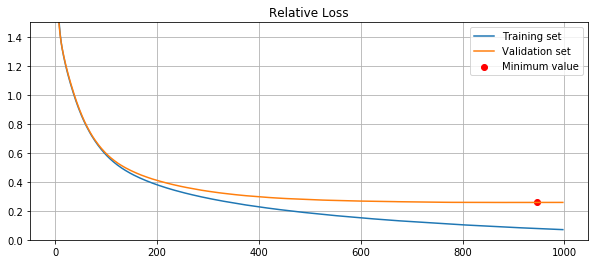

The accuracy achieved is: 0.919 at epoch 947


In [19]:
# Patience is the number of epochs that we have to wait for no
# loss decrease in the validation set to apply early stopping
# instead of waitng till the end of epochs (999)
lr = 0.00005
patience = 50
epochs = 3000
regularizer = 0.000
num_classes = 16

# Instantiate model
nn = MLP1(input_dim=X_train.shape[1], output_dim=16).to(device)
print(nn)
# Set loss and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nn.parameters(), lr=lr, weight_decay=regularizer)
# training
_, _, _ = trainNN(model=nn, patience=patience, best_model_name="low learning rate MLP1",
                epochs=epochs, trainloader=trainloader, valloader=valloader, 
                device=device, optimizer=optimizer, criterion=criterion, plot_upper_y=1.5)

The shallow MLP (1 hidden layer) achieves a stable performance of around 90% in around 60 epochs using a normal learning rate = 0.001 and no regularizer. Early stopping is applied by storing the model of the red dot in the disk so that the best model is kept for futher evaluation.

### Small depth MLP training

In [ ]:
lr = 0.000008
patience = 70
regularizer = 0.0
num_classes = 16
epochs=3000

# Instantiate model
nn1 = MLP2(input_dim=X_train.shape[1], output_dim=16).to(device)
print(nn1)
# Set loss and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nn1.parameters(), lr=lr, weight_decay=regularizer)
# training
_, _, _ = trainNN(model=nn1, patience=patience, best_model_name="low learning rate MLP2",
                epochs=epochs, trainloader=trainloader, valloader=valloader, 
                device=device, optimizer=optimizer, criterion=criterion)

MLP2(
  (fc1): Linear(in_features=200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=16, bias=True)
)
Epoch 1:
Training loss  : 2.7621, Training accuracy  : 0.0541
Validation loss: 2.7450, Validation accuracy: 0.1273
Countdown: 70 

Epoch 2:
Training loss  : 2.7263, Training accuracy  : 0.3055
Validation loss: 2.7066, Validation accuracy: 0.3889
Countdown: 70 

Epoch 3:
Training loss  : 2.6828, Training accuracy  : 0.4001
Validation loss: 2.6576, Validation accuracy: 0.3998
Countdown: 70 

Epoch 4:
Training loss  : 2.6265, Training accuracy  : 0.4020
Validation loss: 2.5929, Validation accuracy: 0.3881
Countdown: 70 

Epoch 5:
Training loss  : 2.5525, Training accuracy  : 0.3863
Validation loss: 2.5086, Validation accuracy: 0.3703
Countdown: 70 

Epoch 6:
Training loss  : 2.4577, Training accuracy  : 0.3703
Validation loss: 2.4023, Val

The small-depth MLP (2 hidden layers) achieves its best best performance (~91%) at around 54 epochs at a lower lerning rate of 5x10^-4. I also store the model parameters in the disk.

### Deep MLP training

MLP3(
  (fc1): Linear(in_features=200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=16, bias=True)
)
Epoch 1:
Training loss  : 2.0788, Training accuracy  : 0.3571
Validation loss: 1.5635, Validation accuracy: 0.4365
Countdown: 90 

Epoch 2:
Training loss  : 1.4189, Training accuracy  : 0.4813
Validation loss: 1.3507, Validation accuracy: 0.4859
Countdown: 90 

Epoch 3:
Training loss  : 1.2789, Training accuracy  : 0.5144
Validation loss: 1.2049, Validation accuracy: 0.5421
Countdown: 90 

Epoch 4:
Training loss  : 1.1217, Training accuracy  : 0.5710
Validation loss: 1.0642, Validation accuracy: 0.6200
Countdown: 90 

Epoch 5:
Training loss  : 1.0062, Training accuracy  : 0.6323
Validation loss: 0.9680, Vali

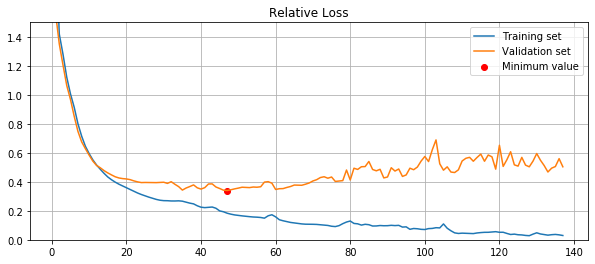

The accuracy achieved is: 0.890 at epoch 47


In [23]:
lr = 0.0001
patience = 90
regularizer = 0.0001
num_classes = 16
epochs = 999

# Instantiate model
nn2 = MLP3(input_dim=X_train.shape[1], output_dim=num_classes).to(device)
print(nn2)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(nn2.parameters(), lr=lr, weight_decay=regularizer)

# training
_, _, _ = trainNN(model=nn2, patience=patience, best_model_name="MLP3",
                  epochs=epochs, trainloader=trainloader, valloader=valloader, 
                  device=device, optimizer=optimizer, criterion=criterion)

The deep MLP (5 hidden layers) confirms the fact that deepening the architecture and increasing the number of parameters won't improve the results. A small regularization coefficient was also used to prevent overfitting.

# Evaluation stage - ML & DL Models

## Classic ML models evaluation
In this section I retrain the chosen ML models on **all the training set** and evaluate them on the uknown test set so as to simulate a real world problem.

SVM 

              precision    recall  f1-score   support

           0      0.923     0.857     0.889        14
           1      0.906     0.897     0.901       428
           2      0.889     0.867     0.878       249
           3      0.744     0.817     0.779        71
           4      0.966     0.972     0.969       145
           5      0.986     0.986     0.986       219
           6      0.875     0.875     0.875         8
           7      0.986     0.979     0.982       143
           8      0.833     0.833     0.833         6
           9      0.919     0.860     0.888       292
          10      0.900     0.931     0.915       737
          11      0.926     0.916     0.921       178
          12      0.968     1.000     0.984        61
          13      0.959     0.976     0.967       380
          14      0.879     0.810     0.843       116
          15      0.964     0.964     0.964        28

    accuracy                          0.921      3075
   macro avg      0.

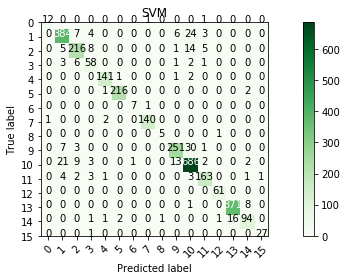

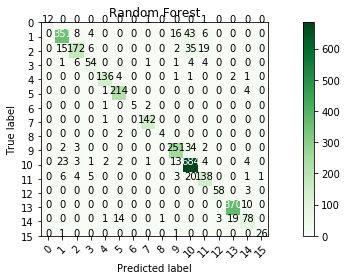

In [20]:
from confusion_matrix import plot_confusion_matrix
X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

ML_models = {'SVM': SVC(kernel='rbf', gamma='scale', C=100),
             'Random Forest': RandomForestClassifier(min_samples_leaf=1, n_estimators=600)}
 
scores=[]
mdl=[]
results=[]
for model in ML_models.keys():
    clf = ML_models[model]
    clf.fit(X_train,  y_train)
    mdl.append(model)
    y_pred = clf.predict(X_test)
    results.append((clf.score(X_test, y_test), y_pred))
    print (model, "\n")
    print(metrics.classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plot_confusion_matrix(cm, classes=list(range(16)), title=model, cmap=plt.cm.Greens)

### Comments on the classic ML models

The SVM rbf algorrithm achieves the best generalisation on the test set. As far as the Random Forest algortithm is concerned, it becomes obvious that pruned trees do not work very well that is nor depth or minimum samples per leaf limitations work well. Furthermore a large number of estimators adds robustness to the model ann achieves better cross validation scores. Important observations:
1. The Random Forest training proves to be significantly slow
2. Cross validation and the large number of estimators prevent the algorithm from overfitting
3. Testing accuracies are higher than training accuracy due to the robustness and stiffness of the cross validation method.

## Neural Network Evaluation

In this section I evaluate the best (stored in disk) multilayer perceptron models after loading their checkpointed versions from the disk. I also import the relevant evaluation function which is developed inside the file training_evaluation.py

In [21]:
from nn_training_evaluation import NN_evaluation

              precision    recall  f1-score   support

           0      0.867     0.929     0.897        14
           1      0.911     0.911     0.911       428
           2      0.873     0.880     0.876       249
           3      0.808     0.887     0.846        71
           4      0.899     0.979     0.937       145
           5      0.977     0.982     0.979       219
           6      1.000     1.000     1.000         8
           7      0.979     0.972     0.975       143
           8      1.000     0.833     0.909         6
           9      0.888     0.866     0.877       292
          10      0.907     0.883     0.895       737
          11      0.877     0.921     0.899       178
          12      0.968     0.984     0.976        61
          13      0.973     0.945     0.959       380
          14      0.817     0.845     0.831       116
          15      0.897     0.929     0.912        28

    accuracy                          0.912      3075
   macro avg      0.915   

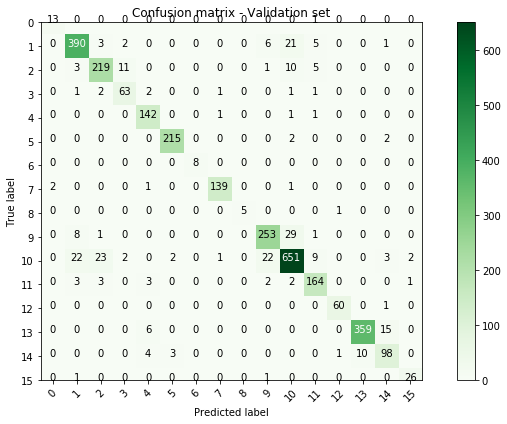

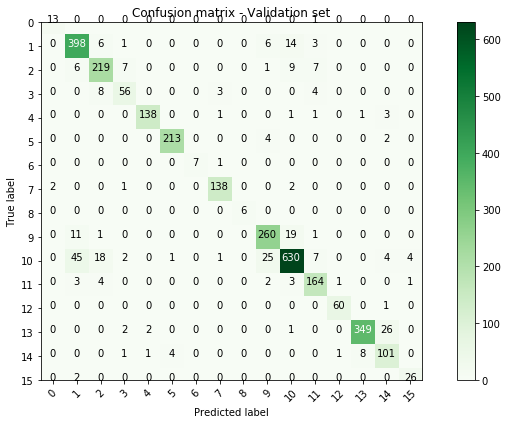

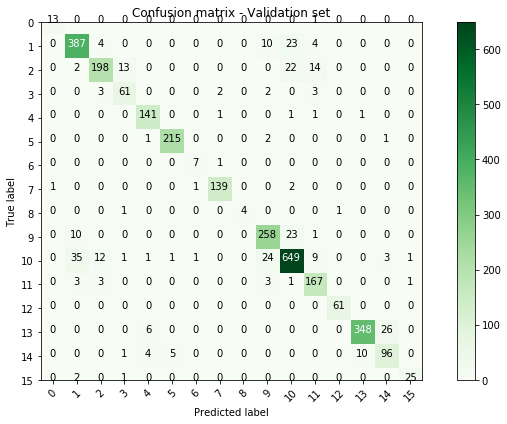

In [22]:
# Model loading from local disk
# Shallow Net (MLP1)
shallownn = torch.load(os.path.join(os.getcwd(),
                   "models"+os.path.sep+"low learning rate MLP1"+".pt"))
shallownn.eval()
_, _, _ = NN_evaluation(model=shallownn, testloader=testloader, 
                        criterion=torch.nn.CrossEntropyLoss().to(device), 
                        device=device)

# Medium net (MLP2)
midnn = torch.load(os.path.join(os.getcwd(),
                   "models"+os.path.sep+"MLP2"+".pt"))
midnn.eval()
_, _, _ = NN_evaluation(model=midnn, testloader=testloader,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        device=device)

# Deep net (MLP3)
dnn = torch.load(os.path.join(os.getcwd(),
                   "models"+os.path.sep+"MLP3"+".pt"))
dnn.eval()
_, _, _ = NN_evaluation(model=dnn, testloader=testloader, 
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        device=device)

### Comments on the neural network models

- Neural networks always tend to overfit if they have a large number of parameters compared to the complexity of the problem. This means that the training loss is always reducing, however the test loss will start increasing after a specific point. This is problem can be solved by keeping a small part of the training set as validation set in order to be able to specify the training hyperparameters (epoch number, learning rate, NN architecture) to avoid entering the overfitting area. The disadvantage of this method is that a part of the training data gets lost (10% serving as validation set). So there is a tradeoff of losing some data in order to apply the right hyperparameter and epoch number selection.
- The **learning rate** selection proved to be important only in terms of the training times of models. Due to the early stopping factor the learning rate values did not affect that much the final losses or accuracies of the models (given that they were in a logical interval [10^-2, 10^-5]). Higher learning rates usually caused imbalance to the training losses while lower learning rates required a large number of epochs to reach appropriate training levels or appeared to get stuck at local minima of the cross entropy loss function achieving lower validation accuracies and higher validation losses. Finally the learning rate appeared to require lower values as the networks deepen in order to prevent quich overfitting and instabilities in the network during the weight updates.
- In terms of regularization it did not prove to be useful, even for the deep MLP (MLP3), where it wasn't really able to improve validation test results even if it managed to reduce the fast overfitting tendencies of the network.
- In general it seems that early stopping is a method that renders the choice of regularization and learning rate parameters less important given that it decides itself for them.